In [12]:
# Import the machine learning libraries.
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Load MNIST dataset.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [14]:
# From sparse label to categorical.
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
# Reshape and normalize input images.
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [16]:
# Network parameters.
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

In [17]:
# Left branch of Y network.
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

# Right branch of Y network.
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

In [18]:
# Merge left and right branches outputs.
y = concatenate([x, y])
# Feature maps to vector before connecting to Dense.
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

In [19]:
# Build the model in functional API.
model = Model([left_inputs, right_inputs], outputs)

In [20]:
# Verify the model using graph.
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file='cnn-y-network.png', show_shapes=True)

# Verify the model using layer text description.
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         input_4[0][0]                    
_______________________________________________________________________________________

In [21]:
# Classifier loss, Adam optimizer, classifier accuracy.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
# Train the model with input images and labels.
history = model.fit([x_train, x_train],
          y_train, 
          validation_data=([x_test, x_test], y_test),
          epochs=20,
          batch_size=batch_size)

Epoch 1/20
1875/1875 [==============================] - 261s 139ms/step - loss: 0.1721 - accuracy: 0.9453 - val_loss: 0.1691 - val_accuracy: 0.9846
Epoch 2/20
1875/1875 [==============================] - 268s 143ms/step - loss: 0.0654 - accuracy: 0.9795 - val_loss: 0.0935 - val_accuracy: 0.9893
Epoch 3/20
1875/1875 [==============================] - 263s 140ms/step - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.0665 - val_accuracy: 0.9931
Epoch 4/20
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0470 - accuracy: 0.9856 - val_loss: 0.0728 - val_accuracy: 0.9926
Epoch 5/20
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.0681 - val_accuracy: 0.9933
Epoch 6/20
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0413 - accuracy: 0.9875 - val_loss: 0.0581 - val_accuracy: 0.9934
Epoch 7/20
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0366 - accuracy: 0.9887 - val_

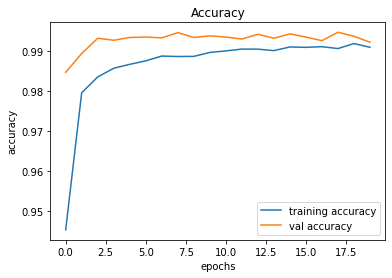

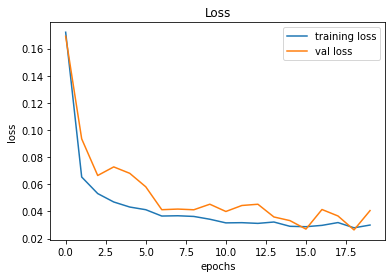

In [23]:
# Plot graphs for accuracy.
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [24]:
# Model accuracy on test dataset.
score = model.evaluate([x_test, x_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 99.2%
